In [1]:
%matplotlib notebook

In [2]:
import torch, itertools
import numpy as np
import matplotlib.pyplot as plt

In [3]:
N = 10
M = 5
K = 10

In [4]:
x = torch.linspace(0,1,N)

In [5]:
y = torch.linspace(0,1,N)

In [6]:
R = torch.stack([x.view(-1,1).expand(N,N), y.view(-1).expand(N,N)], dim=2)

In [7]:
def f(R): #x, y):
    x = R[:,:,0] #.view(-1)
    y = R[:,:,1] #.view(-1)
    alpha = 0.3
    L = 4
    d = 0.3
    f = 0
    f += (2-4*alpha+torch.cos(2*np.pi*x)+torch.cos(2*np.pi*y)).pow(2)
    f += (torch.sin(2*np.pi*x)+torch.sin(2*np.pi*y)).pow(2)
    f *= (L**2)/16
    f -= d**2
    f  = f.abs()
    f  = f.pow(0.5)
    return(f)

In [8]:
E = f(R) #.view(N,N)

<IPython.core.display.Javascript object>


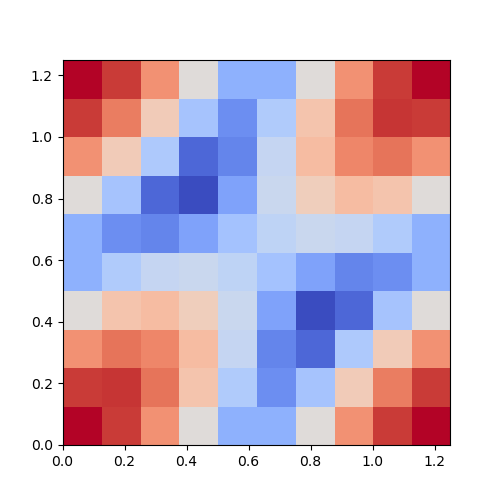

In [9]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0,1.25), ylim=(0,1.25))
im = ax.imshow(E.tolist(), interpolation='nearest', cmap='coolwarm',
    origin='lower', extent=[0,1.25,0,1.25], aspect='auto')

In [10]:
def round_to(arr, n_digits=4):
    rounded = (arr * 10**n_digits).round() / (10**n_digits)
    return(rounded)

In [11]:
def refine(E, R, m):
    def get_n(m):
        n = [N]
        for _m in range(m):
            n.append((n[-1]-1)*M+1)
        return(n[-1])
    n1 = get_n(m-1)
    n2 = get_n(m)
    #E = E.reshape(N*M**(m-1),1,N*M**(m-1),1).expand(N*M**(m-1),M,N*M**(m-1),M).reshape(N*M**m,N*M**m)
    #R = R.reshape(N*M**(m-1),1,N*M**(m-1),1,2).expand(N*M**(m-1),M,N*M**(m-1),M,2).clone()
    E = E.reshape(n1,1,n1,1).expand(n1,M,n1,M).reshape(n1*M,n1*M)
    R = R.reshape(n1,1,n1,1,2).expand(n1,M,n1,M,2).clone()
    for i in range(M):
        R[:,i,:,:,0] += (1.0/(n1-1)/M)*float(i)
        R[:,:,:,i,1] += (1.0/(n1-1)/M)*float(i)
    R = R.reshape(n1*M,n1*M,2)
    E = E[:n2,:n2] #E[:-M+1,:-M+1]
    R = R[:n2,:n2] #R[:-M+1,:-M+1]    
    E_cutoff = round_to(E.unique(), n_digits=4).unique()[:K].max()
    idx = torch.nonzero((round_to(E, n_digits=4)<=E_cutoff).to(torch.long))
    A = np.arange(-2*M,2*M+1).tolist()
    A = list(itertools.product(A,A))
    #A = list(itertools.combinations_with_replacement(torch.arange(-M,M+1).tolist(), r=2))
    A = torch.tensor([list(a) for a in A]).view(1,-1,2)
    idx = idx.unsqueeze(1)
    idx = idx + A
    idx = idx.reshape(-1,2)
    idx = idx.unique(dim=0)
    j = torch.nonzero((idx >= 0).to(torch.long).prod(dim=1)*(
        idx < n2).to(torch.long).prod(dim=1)).view(-1)
    idx = idx[j]
    E[idx[:,0],idx[:,1]] = f(R)[idx[:,0],idx[:,1]] #.view(N*M,N*M)
    fig = plt.figure(figsize=(5,5))
    pad = 1.0/(n1-1)/M
    ax = fig.add_subplot(111, autoscale_on=False, xlim=(0,1+pad), ylim=(0,1+pad))
    im = ax.imshow(E, interpolation='nearest', cmap='coolwarm',
        origin='lower', extent=[0,1+pad,0,1+pad], aspect='auto')
    return(E, R)

<IPython.core.display.Javascript object>


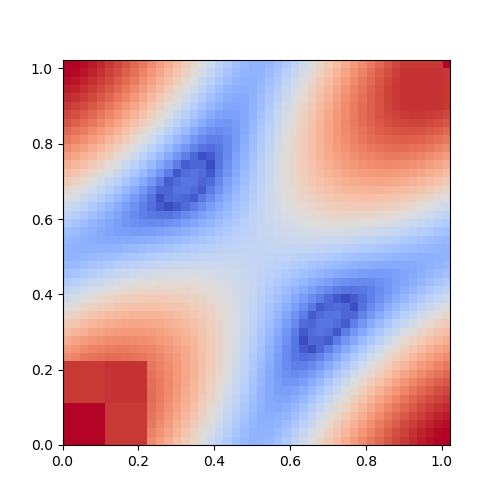

<IPython.core.display.Javascript object>


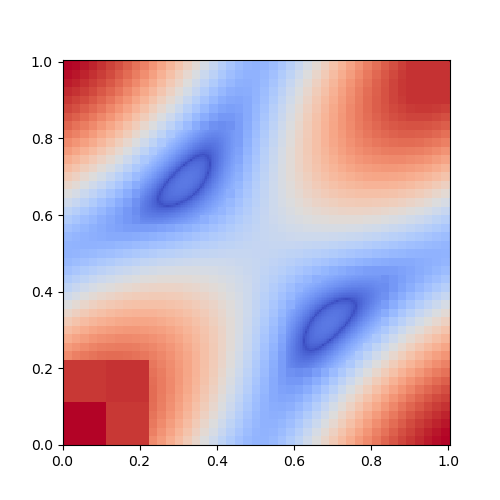

<IPython.core.display.Javascript object>


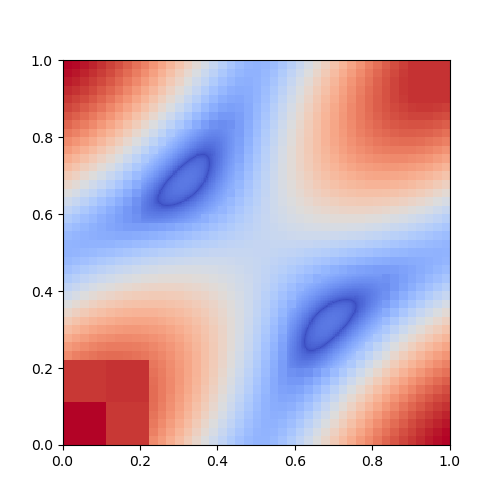

In [12]:
for m in range(1,4):
    E, R = refine(E, R, m)